In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load the data we processed in the previous step
df = pd.read_csv('../data/processed/brent_processed.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Now define 'data' for the PyMC model
data = df['Price'].values
n_data = len(data)
idx = np.arange(n_data)

print(f"Data loaded successfully. Total observations: {n_data}")

Data loaded successfully. Total observations: 9010


/home/rahel/Desktop/kaim-week9/venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


/home/rahel/Desktop/kaim-week9/venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'mu_1'}>,
        <Axes: title={'center': 'mu_1'}>],
       [<Axes: title={'center': 'mu_2'}>,
        <Axes: title={'center': 'mu_2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

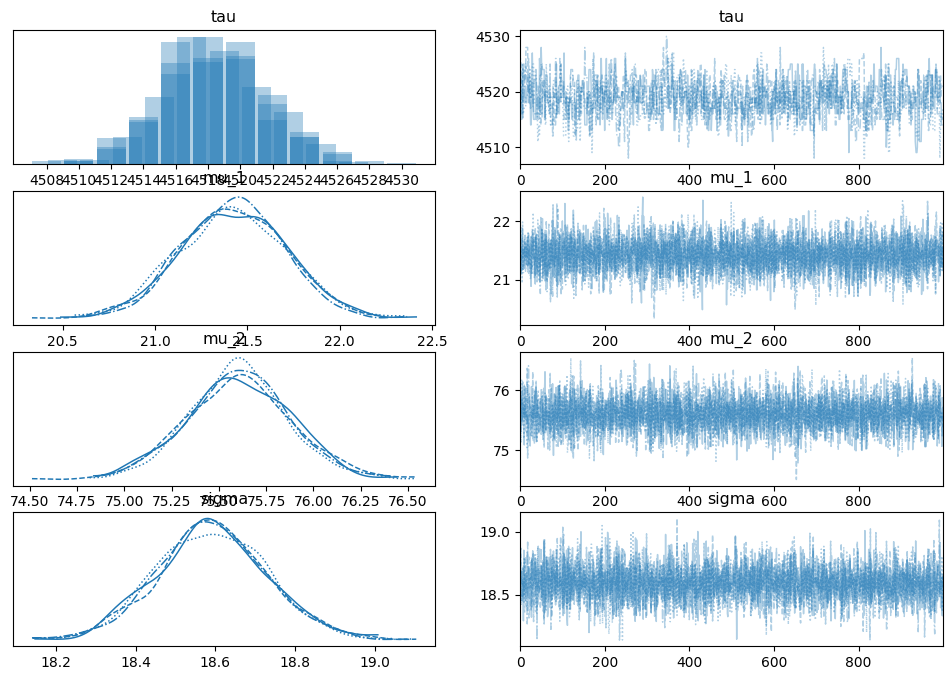

In [3]:
import pymc as pm
import numpy as np

# Prepare data for PyMC (using a subset or downsampled data for speed)
data = df['Price'].values
n_data = len(data)
idx = np.arange(n_data)

with pm.Model() as change_point_model:
    # Prior for the time index where the switch happens
    switch_point = pm.DiscreteUniform("tau", lower=0, upper=n_data - 1)
    
    # Priors for the mean prices before and after the switch
    mu_1 = pm.Exponential("mu_1", lam=1.0/data.mean())
    mu_2 = pm.Exponential("mu_2", lam=1.0/data.mean())
    
    # Prior for standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Allocate the correct mean to each day based on tau
    mu_ = pm.math.switch(switch_point >= idx, mu_1, mu_2)
    
    # Likelihood
    observed = pm.Normal("obs", mu=mu_, sigma=sigma, observed=data)
    
    # Inference
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Check results
import arviz as az
az.plot_trace(trace)